Data scraped from the following websites:

1) [Wikepedia districts and subdistricts of KL and Selangor](#scrape): https://en.wikipedia.org/wiki/Selangor

2) [Geopy coordinates](#geocode)

3) [Foursquare list of restaurants in KL and Selangor](#foursquare)

---

In [1]:
import pandas as pd
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import folium
from geopy.geocoders import Nominatim
from tqdm import tqdm
import time

---

<a id='scrape'></a>
<u>**Wikepedia districts and subdistricts of KL and Selangor**</u>

In [2]:
url = 'https://en.wikipedia.org/wiki/Selangor'
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')

Wikepedia presents the data I want in the following table format:

<div>
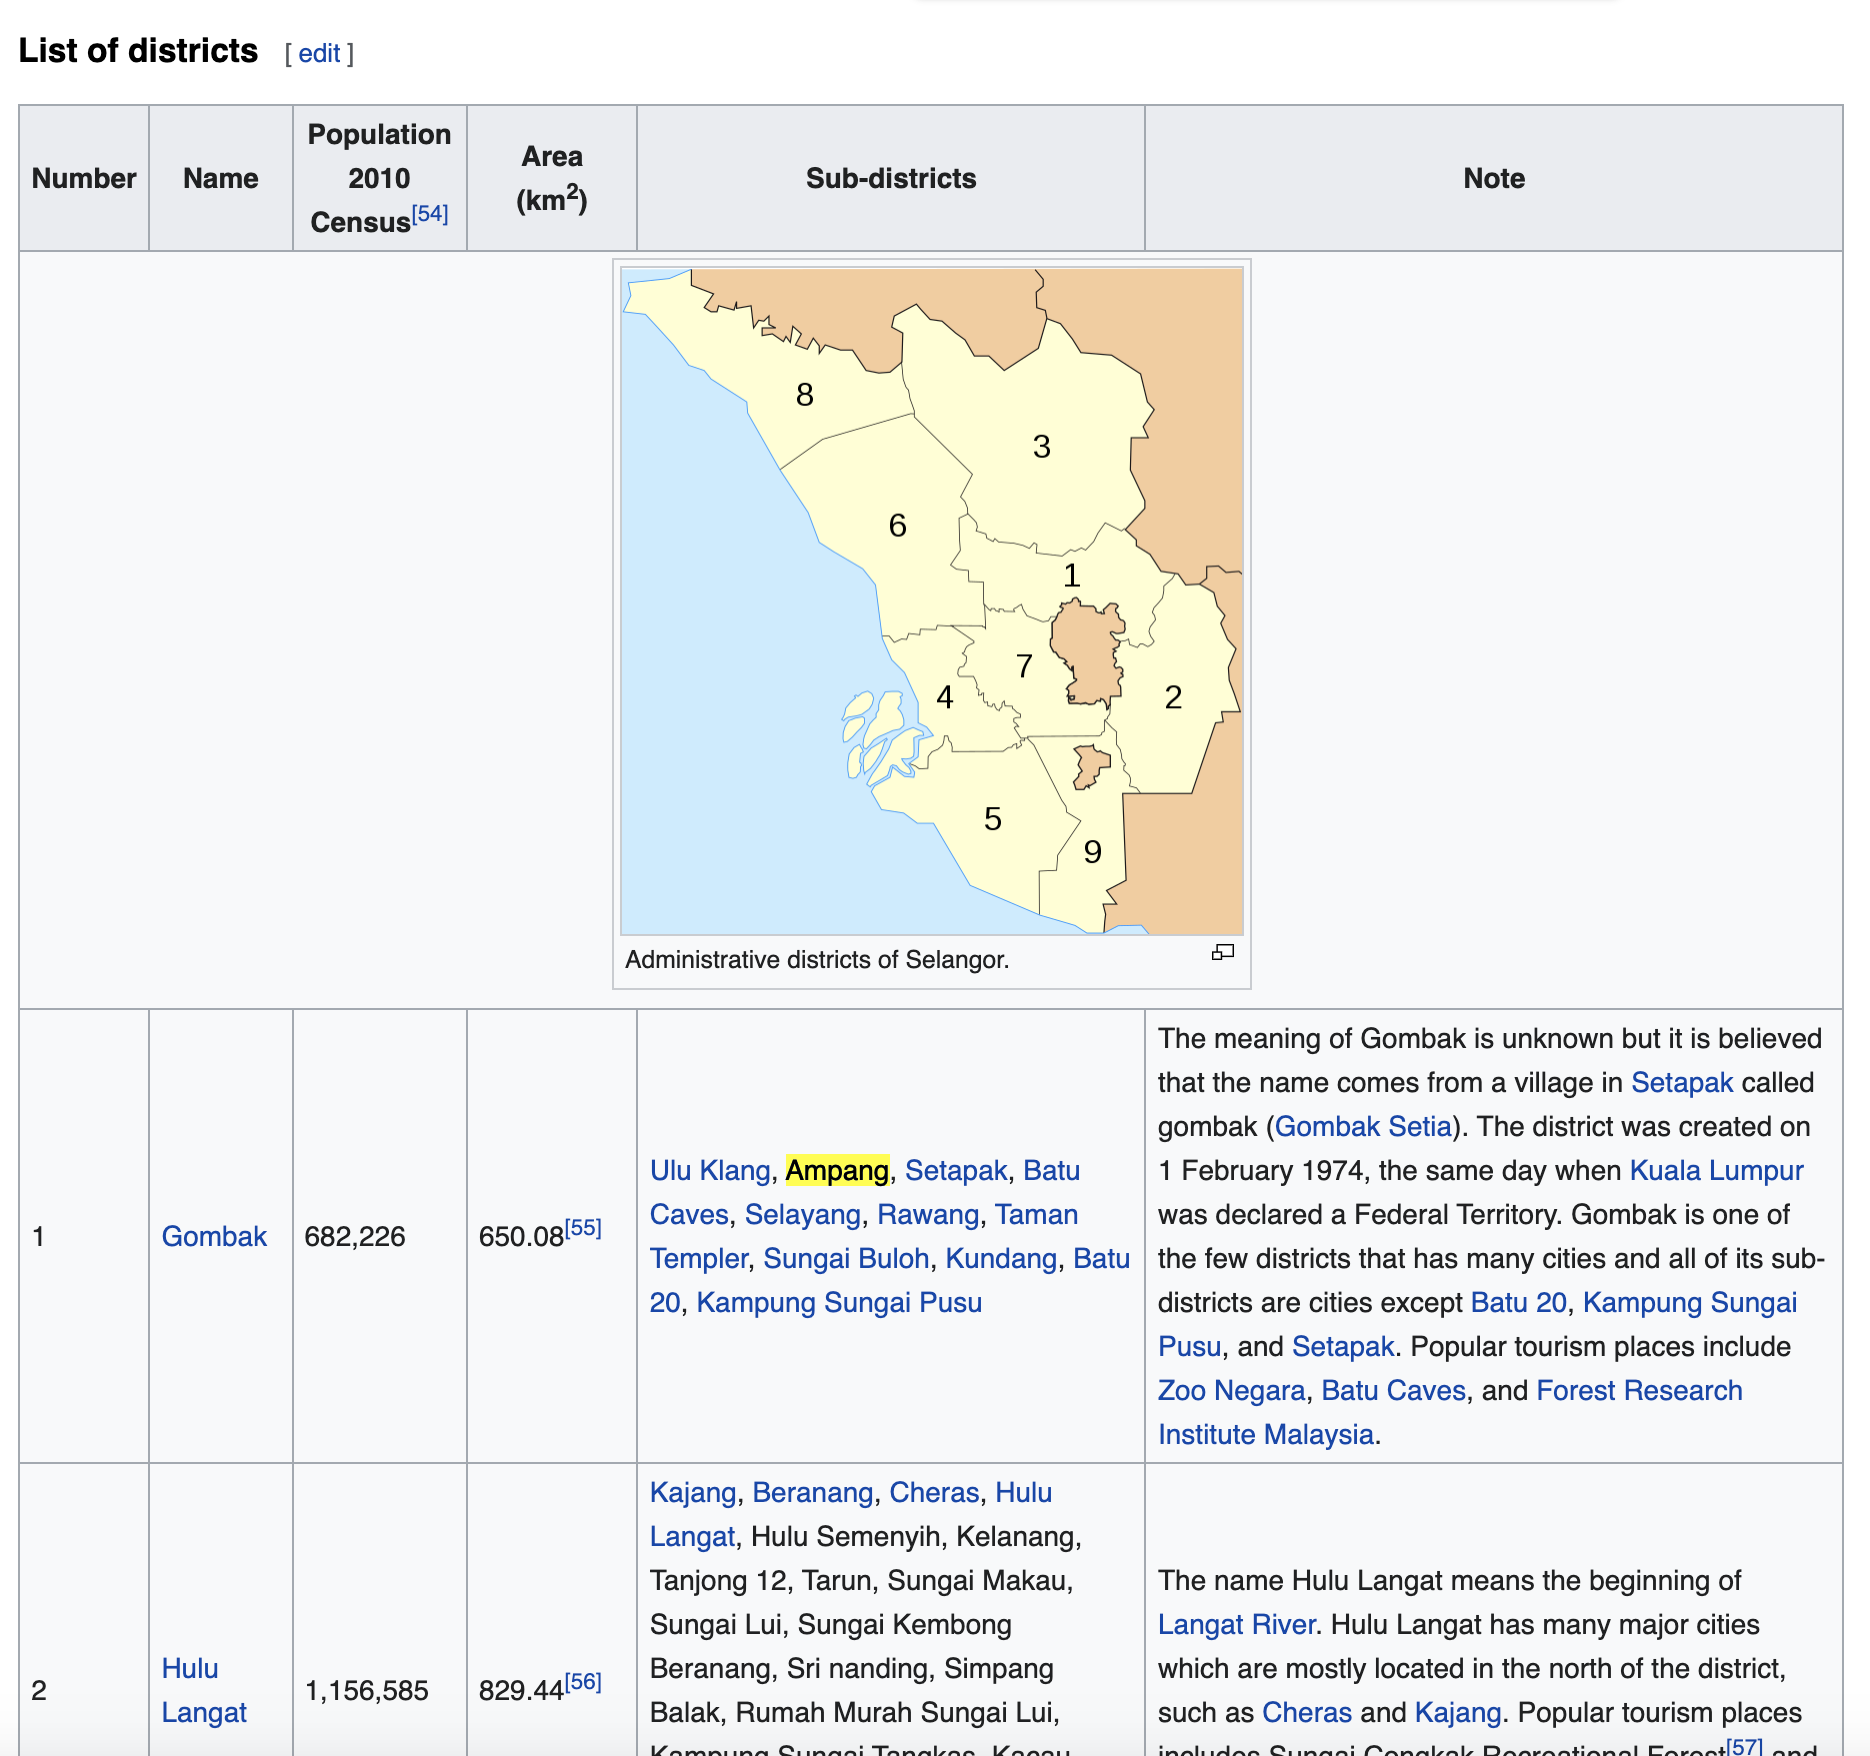
</div>

We can find the data stored under subsection `table` with class `wikitable`, within which we can find each column of the table under `td`.

I only want the 2nd (district) and 5th (subdistrict) columns of the table. These correspond to the 6th index under `td` after the 2nd index for districts and after the 5th index for subdistricts.


In [3]:
# get corresponding indexes
dist_index = np.arange(2, 100, 6).tolist()
subdist_index = np.arange(5, 100, 6).tolist()

# store results in empty lists
dists = []
subdists = []

for i in dist_index:
    try:
        dist = soup.find_all('table', class_='wikitable')[4].find_all('td')[i].text
        dists.append(dist)
    except:
        pass
        
for j in subdist_index:
    try:
        subdist = soup.find_all('table', class_='wikitable')[4].find_all('td')[j].text
        subdists.append(subdist)
    except:
        pass
        
# append results into a fresh dataframe
locations = pd.DataFrame(list(zip(dists, subdists)), columns=['districts','subdistricts'])

In [4]:
locations

,districts,subdistricts
0,Gombak,"Ulu Klang, Ampang, Setapak, Batu Caves, Selaya..."
1,Hulu Langat,"Kajang, Beranang, Cheras, Hulu Langat, Hulu Se..."
2,Hulu Selangor,"Kuala Kubu Bharu, Sungai Chick, Ulu Yam, Ulu Y..."
3,Klang,"Klang, Kapar, Bukit Raja, Port Klang, Pandamar..."
4,Kuala Langat,"Bandar Saujana Putra, Jenjarom, Kanchong Darat..."
5,Kuala Selangor,"Api-api, Kuala Selangor, Puncak Alam, Bukit Me..."
6,Petaling,"Petaling Jaya, Subang Jaya, Shah Alam, Damansa..."
7,Sabak Bernam,"Sabak, Sungai Besar, Sekinchan."
8,Sepang,"Puchong, Bukit Puchong 2, 16 Sierra, Taman Put..."


I will do some data cleaning to have each row represented by each pair of district and subdistrict.

In [5]:
locations['subdistricts'] = locations['subdistricts'].str.split(',')
locations = locations.explode('subdistricts')
locations.reset_index(drop=True, inplace=True)

# remove whitespaces, standardize texts etc
locations['subdistricts'] = locations['subdistricts'].str.replace('.', '').str.strip()

<ipython-input-5-295fd6b6fa6b>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  locations['subdistricts'] = locations['subdistricts'].str.replace('.', '').str.strip()


Some data quality assurance:

Check if there are any duplicated subdistricts?

- There are 2 duplicated subdistricts: Beranang in Hulu Langat and Sepang, and Puchong in Petaling and Sepang.

- After some digging, I will consider Beranang to be in the Hulu Langat district, while Puchong is in the Petaling district.

I am finally left with a total of **120 unique subdistricts across 9 districts** in Selangor.

In [6]:
locations['subdistricts'].duplicated().sum()

2

In [7]:
locations[locations['subdistricts'].duplicated()]

,districts,subdistricts
110,Sepang,Puchong
120,Sepang,Beranang


In [8]:
locations[locations['subdistricts'] == 'Beranang']

,districts,subdistricts
12,Hulu Langat,Beranang
120,Sepang,Beranang


In [9]:
locations[locations['subdistricts'] == 'Puchong']

,districts,subdistricts
96,Petaling,Puchong
110,Sepang,Puchong


In [10]:
locations.drop(120, inplace=True)
locations.drop(110, inplace=True)

In [11]:
locations['subdistricts'].duplicated().sum()

0

I will manually impute the districts and subdistricts of Kuala Lumpur:

Mont Kiara, Bukit Bintang, Sentul, Bangsar, Sunway, Setia Alam.

In [12]:
kl_subdistricts = ['Mont Kiara', 'Bukit Bintang', 'Sentul',
                   'Bangsar', 'Sunway', 'Setia Alam']
kl_districts = ['Kuala Lumpur']*6

In [13]:
kl_locations = pd.DataFrame(list(zip(kl_districts, kl_subdistricts)), columns=['districts','subdistricts'])               

In [14]:
locations = locations.append(kl_locations)
locations.reset_index(drop=True, inplace=True)

---

<a id='geocode'></a>
<u>**Geocode subdistricts using Geopy**</u>

Geocoding is a computational process that transforms a physical address to a location's coordinates.

In [15]:
# add malaysia column to df
locations['country'] = 'Malaysia'
locations['address'] = locations['subdistricts'] + ', ' + locations['districts'] + ', ' + locations['country']
locations['latitude'] = ''
locations['longitude'] = ''

In [16]:
locations.head()

,districts,subdistricts,country,address,latitude,longitude
0,Gombak,Ulu Klang,Malaysia,"Ulu Klang, Gombak, Malaysia",,
1,Gombak,Ampang,Malaysia,"Ampang, Gombak, Malaysia",,
2,Gombak,Setapak,Malaysia,"Setapak, Gombak, Malaysia",,
3,Gombak,Batu Caves,Malaysia,"Batu Caves, Gombak, Malaysia",,
4,Gombak,Selayang,Malaysia,"Selayang, Gombak, Malaysia",,


In [17]:
for i,j in tqdm(locations.iterrows()):
    try:
        locator = Nominatim(user_agent='myGeocoder')
        location = locator.geocode(j['address'])
        lat = location.latitude
        lng = location.longitude
        locations.loc[i, 'latitude'] = lat
        locations.loc[i, 'longitude'] = lng
    except:
        print(f"Can't geocode {j['address']}")

8it [00:07,  1.46s/it]

Can't geocode Sungai Buloh, Gombak, Malaysia


11it [00:09,  1.08it/s]

Can't geocode Kampung Sungai Pusu, Gombak, Malaysia


17it [00:12,  1.71it/s]

Can't geocode Kelanang, Hulu Langat, Malaysia



18it [00:13,  1.74it/s]

Can't geocode Tanjong 12, Hulu Langat, Malaysia



19it [00:13,  1.72it/s]

Can't geocode Tarun, Hulu Langat, Malaysia



20it [00:14,  1.74it/s]

Can't geocode Sungai Makau, Hulu Langat, Malaysia


22it [00:15,  1.78it/s]

Can't geocode Sungai Kembong Beranang, Hulu Langat, Malaysia


25it [00:17,  1.78it/s]

Can't geocode Rumah Murah Sungai Lui, Hulu Langat, Malaysia


27it [00:18,  1.78it/s]

Can't geocode Kacau, Hulu Langat, Malaysia



28it [00:18,  1.76it/s]

Can't geocode Kampung Pasir Batu 14 Semenyih, Hulu Langat, Malaysia


34it [00:22,  1.82it/s]

Can't geocode Sungai Chick, Hulu Selangor, Malaysia


36it [00:23,  1.78it/s]

Can't geocode Ulu Yam Baru, Hulu Selangor, Malaysia


50it [00:30,  1.91it/s]

Can't geocode Telok Menegun, Klang, Malaysia


59it [00:35,  1.84it/s]

Can't geocode Tongkah, Kuala Langat, Malaysia


61it [00:36,  1.86it/s]

Can't geocode Telok, Kuala Langat, Malaysia



62it [00:37,  1.87it/s]

Can't geocode Sungai Raba, Kuala Langat, Malaysia


65it [00:38,  1.82it/s]

Can't geocode Kelanang Batu 6, Kuala Langat, Malaysia


78it [00:45,  1.76it/s]

Can't geocode Pasangan, Kuala Selangor, Malaysia



79it [00:46,  1.78it/s]

Can't geocode Ulu Tinggi, Kuala Selangor, Malaysia



80it [00:47,  1.75it/s]

Can't geocode Ujong Permatang, Kuala Selangor, Malaysia



81it [00:50,  1.43s/it]

Can't geocode Tambak Jawa, Kuala Selangor, Malaysia



82it [00:51,  1.27s/it]

Can't geocode Taman PKNS, Kuala Selangor, Malaysia


84it [00:52,  1.11it/s]

Can't geocode Simpang 3 Ijok, Kuala Selangor, Malaysia


87it [00:54,  1.47it/s]

Can't geocode Parit Mahang, Kuala Selangor, Malaysia



88it [00:54,  1.56it/s]

Can't geocode Kg Baru Hulu Tiram Buruk, Kuala Selangor, Malaysia



89it [00:55,  1.60it/s]

Can't geocode Bukit Talang, Kuala Selangor, Malaysia


96it [00:59,  1.75it/s]

Can't geocode Country Heights, Petaling, Malaysia


104it [01:03,  1.84it/s]

Can't geocode Penaga, Petaling, Malaysia


111it [01:07,  1.79it/s]

Can't geocode Bukit Puchong 2, Sepang, Malaysia


126it [01:15,  1.67it/s]

Can't geocode Setia Alam, Kuala Lumpur, Malaysia


There may be locations that fail to be recognised and hence geocoded.

In [18]:
missing_coords = len(locations[locations['latitude']==''])
print(f"{missing_coords} out of {len(locations)} neighborhoods cannot be geocoded: {round(missing_coords/len(locations),2)*100}%")

30 out of 126 neighborhoods cannot be geocoded: 24.0%


Let's look at the geocoded coordinates on a Folium map.

<u>**Plot geocoded coordinates on Folium map**</u>

Keep the latitude, longitude, and subdistricts columns

In [19]:
locations_folium = locations[['subdistricts','latitude','longitude']]
locations_folium = locations_folium[locations_folium['latitude']!='']

In [20]:
map_f = folium.Map()

for i, j in locations_folium.iterrows():
    folium.Marker([j['latitude'], j['longitude']], popup=j['subdistricts']).add_to(map_f)
    
sw = locations_folium[['latitude','longitude']].min().values.tolist()
ne = locations_folium[['latitude','longitude']].max().values.tolist()

map_f.fit_bounds([sw, ne])
map_f

I will remove locations that cannot be geocoded (i.e. no coordinates).

In [21]:
locations = locations[locations['latitude']!='']
locations.reset_index(drop=True, inplace=True)
len(locations)

96

In [22]:
# locations_toreplace = missing_locations[missing_locations['latitude']!='']

# # concat the new locations with updated coordinates to original df, and remove first record
# locations = pd.concat([locations, locations_toreplace], axis=0).drop_duplicates('subdistricts',
#                                                                                 keep='last')

Some coordinates are relatively close to each other, which saturates the map and makes the visualization messy. For example, Damansara and Kayu Ara are pinned closely to each other, as well as Sri Batu and Sri Nanding.

Since the exercise is to cluster neighborhoods together based on cuisine categories, locations close to each other may have overlapping restaurants. I will remove one of these pairs for simplicity.  


In [23]:
# convert coordinates from object to float
locations['latitude'] = locations['latitude'].astype(float)
locations['longitude'] = locations['longitude'].astype(float)

In [24]:
# define function to calculate distances between each pin
def calculate_distance(df1, df2):
    global locations_final
    
    # from df2, remove the row that df1 selected
    subdist = df1['subdistricts'].values.tolist()[0]
    df2 = df2[df2['subdistricts']!=subdist].reset_index(drop=True)
    
    # Convert latitude and longitude pairs into numpy array
    coord1 = df1[['latitude', 'longitude']].to_numpy()
    coord2 = df2[['latitude', 'longitude']].to_numpy()

    # Convert coordinates to radians
    rad1, rad2 = np.radians(coord1), np.radians(coord2)

    # Get the differentiations between each HDB and all MRT stations for their latitudes and longitudes, separately
    lat = rad2[:,0] - rad1[:,0,None]
    lng = rad2[:,1] - rad1[:,1,None]

    # Compute the differentiation results in the Haversine function
    add0 = np.cos(rad1[:,0,None]) * np.cos(rad2[:,0]) * np.sin(lng*0.5)**2
    d = np.sin(lat*0.5)**2 + add0

    # Calculate the nearest distance and store it into the dataframe
    AVG_EARTH_RADIUS = 6.3781*1e6
    haversine_distances = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    
    # Get nearest subdistrict and note it down into df, as well as the distance in meter
    df1['nearest_subdist'] = haversine_distances.argmin(1)
    df1['min_distance_m'] = haversine_distances.min(1)
    df1['min_distance_m'] = round(df1['min_distance_m'], 2)
    
    df2['index'] = range(0, len(df2))
    df2_map = df2.set_index('index')[['subdistricts']].T.to_dict('records')[0]
    df1['nearest_subdist'] = df1['nearest_subdist'].map(df2_map)
    
    locations_final = locations_final.append(df1)
    

In [25]:
locations_final = pd.DataFrame(columns=locations.columns)

# apply function defined above to each row in the locations df
# it has to be row by row because the function is built to compare each row
# in question to all locations except the subdistrict of the row in question
# otherwise, the same subdistrict would be selected as the closest
for i,j in locations.iterrows():
    locations_row = pd.DataFrame(locations.loc[i, :]).transpose()
    locations_row['latitude'] = locations_row['latitude'].astype(float)
    locations_row['longitude'] = locations_row['longitude'].astype(float)
    calculate_distance(locations_row, locations)

Seems like there are a number of subdistricts with proximities that are less than 1km from its neighboring subdistrict.

I will remove one of each identified pair. 

In [26]:
# look for distances that are less than 2k
locations_final[locations_final['min_distance_m'] <= 3000]

,districts,subdistricts,country,address,latitude,longitude,nearest_subdist,min_distance_m
0,Gombak,Ulu Klang,Malaysia,"Ulu Klang, Gombak, Malaysia",3.163062,101.751884,Ampang,1699.62
1,Gombak,Ampang,Malaysia,"Ampang, Gombak, Malaysia",3.150256,101.760210,Ulu Klang,1699.62
2,Gombak,Setapak,Malaysia,"Setapak, Gombak, Malaysia",3.190238,101.706176,Sentul,1756.99
3,Gombak,Batu Caves,Malaysia,"Batu Caves, Gombak, Malaysia",3.237451,101.681226,Batu 20,354.22
8,Gombak,Batu 20,Malaysia,"Batu 20, Gombak, Malaysia",3.238135,101.684339,Batu Caves,354.22
11,Hulu Langat,Cheras,Malaysia,"Cheras, Hulu Langat, Malaysia",3.073076,101.762685,Hulu Langat,80.94
12,Hulu Langat,Hulu Langat,Malaysia,"Hulu Langat, Hulu Langat, Malaysia",3.072769,101.762025,Cheras,80.94
14,Hulu Langat,Sungai Lui,Malaysia,"Sungai Lui, Hulu Langat, Malaysia",3.171175,101.861240,Batu 23,2698.40
15,Hulu Langat,Sri nanding,Malaysia,"Sri nanding, Hulu Langat, Malaysia",3.100961,101.804673,Batu 26,741.62
18,Hulu Langat,Desa Raya,Malaysia,"Desa Raya, Hulu Langat, Malaysia",3.083725,101.788354,Batu 26,1925.71


In [27]:
short_distance = locations_final[locations_final['min_distance_m'] <= 3000]
short_distance_remove_list = short_distance[['subdistricts','nearest_subdist']].values.tolist()

# remove duplicates from short_distance_remove
dup = []

for i in short_distance_remove_list:
    dup.append(', '.join(np.sort(i)))
    
short_distance.reset_index(drop=True, inplace=True)
short_distance['dup'] = pd.Series(dup)

short_distance.drop_duplicates('dup', keep='first', inplace=True)
    

<ipython-input-27-aa41539fa3a3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_distance['dup'] = pd.Series(dup)
<ipython-input-27-aa41539fa3a3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_distance.drop_duplicates('dup', keep='first', inplace=True)


In [28]:
# combine above with original df
locations_final = locations_final[locations_final['min_distance_m'] > 3000]
locations_final = pd.concat([locations_final, short_distance])
locations_final.reset_index(drop=True, inplace=True)

In [29]:
len(locations_final)

78

In [30]:
locations_final_folium = locations_final[['subdistricts','latitude','longitude']]

map_f2 = folium.Map()

for i, j in locations_final_folium.iterrows():
    folium.Marker([j['latitude'], j['longitude']], popup=j['subdistricts']).add_to(map_f2)
    
sw2 = locations_final_folium[['latitude','longitude']].min().values.tolist()
ne2 = locations_final_folium[['latitude','longitude']].max().values.tolist()

map_f2.fit_bounds([sw2, ne2])
map_f2

---

<a id='foursquare'></a>
<u>**Foursquare list of restaurants in the Klang Valley**</u>

First, get credentials for Foursquare API access. More info: https://annie-wangliu.medium.com/using-foursquare-api-basice-functions-7c5130951d96

Second, define API URL and send GET Requests. 

Third, identify important parameters to get from API, such as coordinates, radius of search, limit of items to extract, category ID etc. 

List of categories and their IDs may be found [here](https://developer.foursquare.com/docs/build-with-foursquare/categories/). 

A category may be `Food`, with its ID corresponding to `4d4b7105d754a06374d81259`. 

Another category may be `Event` with ID `4d4b7105d754a06373d81259`. 

Moreover within the `Food` category are of various cuisines such as `African`, `Asian`, and more. Since there are at least 50 different types of cuisines identified by Foursquare, I will only look at a handful of cuisines. These are defined explicitly below to be queried from Foursquare.

In [52]:
# define parameters that will remain unchanged
radius = 3000
LIMIT = 100

# get all food cuisines in a list for iteration 
cuisines_map = {
    'Afghan': '503288ae91d4c4b30a586d67', 
    'African': '4bf58dd8d48988d1c8941735', 
    'American': '4bf58dd8d48988d14e941735', 
    'Burmese': '56aa371be4b08b9a8d573568', 
    'Cambodian': '52e81612bcbc57f1066b7a03', 
    'Chinese': '4bf58dd8d48988d145941735', 
    'Filipino': '4eb1bd1c3b7b55596b4a748f',
    'Indonesian': '4deefc054765f83613cdba6f', 
    'Japanese': '4bf58dd8d48988d111941735', 
    'Korean': '4bf58dd8d48988d113941735', 
    'Malay': '4bf58dd8d48988d156941735', 
    'Mongolian': '4eb1d5724b900d56c88a45fe', 
    'Thai': '4bf58dd8d48988d149941735', 
    'Vietnamese': '4bf58dd8d48988d14a941735', 
    'Bangladeshi': '5e179ee74ae8e90006e9a746', 
    'Caribbean': '4bf58dd8d48988d144941735',
    'English': '52e81612bcbc57f1066b7a05', 
    'French': '4bf58dd8d48988d10c941735', 
    'German': '4bf58dd8d48988d10d941735', 
    'Indian': '4bf58dd8d48988d10f941735', 
    'Italian': '4bf58dd8d48988d110941735',  
    'Mediterranean': '4bf58dd8d48988d1c0941735', 
    'Mexican': '4bf58dd8d48988d1c1941735',
    'Pakistani': '52e81612bcbc57f1066b79f8', 
    'Portuguese': '4def73e84765ae376e57713a', 
    'Russian': '5293a7563cf9994f4e043a44',
    'Spanish': '4bf58dd8d48988d150941735', 
    'Sri Lankan': '5413605de4b0ae91d18581a9', 
    'Middle Eastern': '4bf58dd8d48988d115941735',
    'South American': '4bf58dd8d48988d1be941735'
}

cuisines = list(zip(cuisines_map.keys(), cuisines_map.values()))
len(cuisines)

12

Loop through all subdistricts (row by row) to request info from Foursquare API. 

Since the API has a daily limit of 1k requests a day for free accounts, I create multiple accounts to bypass this :-) 

In [53]:
# initialise empty lists to store results from GET request: restaurant name and coordinates
restaurant_name = []
restaurant_cuisine = []
restaurant_lat = []
restaurant_long = []
restaurant_subdistrict = []

# go through all cuisines
iteration = 0

for a in cuisines:
    cuisine = a[0]
    cuisine_code = a[1]
    
    # create new columns of each food cuisine in original df
    locations_final[cuisine] = ''
    for i,j in locations_final.iterrows():
        iteration += 1 
        if iteration <= 930:
            rest_subdistrict = j['subdistricts']
            latitude = j['latitude']
            longitude = j['longitude']
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                  CLIENT_ID1,
                  CLIENT_SECRET1,
                  VERSION,
                  latitude,
                  longitude, 
                  radius,
                  LIMIT,
                  cuisine_code)

            time.sleep(0.5)
            results = requests.get(url).json()['response']['groups'][0]['items']
            rest_number = len(results)
            print(f"ITERATION {iteration}")
            print(f"Coords {i} have {rest_number} restaurants for {cuisine}")

            # insert restaurant_number into new columns of og df
            locations_final.loc[i, cuisine] = rest_number

            # insert new data into empty lists
            for b in range(0, rest_number):
                rest_name = results[b]['venue']['name']
                rest_cuisine = results[b]['venue']['categories'][0]['name']
                rest_lat = results[b]['venue']['location']['lat']
                rest_long = results[b]['venue']['location']['lng']
                print(f"{b}: {rest_name}")

                restaurant_name.append(rest_name)
                restaurant_cuisine.append(rest_cuisine)
                restaurant_lat.append(rest_lat)
                restaurant_long.append(rest_long)
                restaurant_subdistrict.append(rest_subdistrict)
                
        elif (iteration > 930) and (iteration <= 1860):
            rest_subdistrict = j['subdistricts']
            latitude = j['latitude']
            longitude = j['longitude']
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                  CLIENT_ID2,
                  CLIENT_SECRET2,
                  VERSION,
                  latitude,
                  longitude, 
                  radius,
                  LIMIT,
                  cuisine_code)

            time.sleep(0.5)
            results = requests.get(url).json()['response']['groups'][0]['items']
            rest_number = len(results)
            print(f"ITERATION {iteration}")
            print(f"Coords {i} have {rest_number} restaurants for {cuisine}")

            # insert restaurant_number into new columns of og df
            locations_final.loc[i, cuisine] = rest_number

            # insert new data into empty lists
            for b in range(0, rest_number):
                try:
                    rest_name = results[b]['venue']['name']
                    rest_cuisine = results[b]['venue']['categories'][0]['name']
                    rest_lat = results[b]['venue']['location']['lat']
                    rest_long = results[b]['venue']['location']['lng']
                    print(f"{b}: {rest_name}")

                    restaurant_name.append(rest_name)
                    restaurant_cuisine.append(rest_cuisine)
                    restaurant_lat.append(rest_lat)
                    restaurant_long.append(rest_long)
                    restaurant_subdistrict.append(rest_subdistrict)
                except:
                    pass
        
        elif iteration > 1860:
            rest_subdistrict = j['subdistricts']
            latitude = j['latitude']
            longitude = j['longitude']
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                  CLIENT_ID3,
                  CLIENT_SECRET3,
                  VERSION,
                  latitude,
                  longitude, 
                  radius,
                  LIMIT,
                  cuisine_code)

            time.sleep(0.5)
            results = requests.get(url).json()['response']['groups'][0]['items']
            rest_number = len(results)
            print(f"ITERATION {iteration}")
            print(f"Coords {i} have {rest_number} restaurants for {cuisine}")

            # insert restaurant_number into new columns of og df
            locations_final.loc[i, cuisine] = rest_number

            # insert new data into empty lists
            for b in range(0, rest_number):
                try:
                    rest_name = results[b]['venue']['name']
                    rest_cuisine = results[b]['venue']['categories'][0]['name']
                    rest_lat = results[b]['venue']['location']['lat']
                    rest_long = results[b]['venue']['location']['lng']
                    print(f"{b}: {rest_name}")

                    restaurant_name.append(rest_name)
                    restaurant_cuisine.append(rest_cuisine)
                    restaurant_lat.append(rest_lat)
                    restaurant_long.append(rest_long)
                    restaurant_subdistrict.append(rest_subdistrict)
                except:
                    pass
            


ITERATION 1409
Coords 0 have 0 restaurants for German
ITERATION 1410
Coords 1 have 0 restaurants for German
ITERATION 1411
Coords 2 have 0 restaurants for German
ITERATION 1412
Coords 3 have 0 restaurants for German
ITERATION 1413
Coords 4 have 2 restaurants for German
0: 21st Century Cafe
ITERATION 1414
Coords 5 have 0 restaurants for German
ITERATION 1415
Coords 6 have 0 restaurants for German
ITERATION 1416
Coords 7 have 0 restaurants for German
ITERATION 1417
Coords 8 have 20 restaurants for German
0: Warong FZ Seafood Corner (Roslan Corner)
1: Wak Dol Cafe German Malaysian Institute
2: German Malaysia Institute (GMI)
3: Dewan Gemilang Mercu Idaman, German-Malaysian Institute
4: Marketing. & Corporate Affairs Unit, Admin Block, German-Malaysian Institute
5: Sport Complex Cafe, German-Malaysian Institute
6: German Malaysian Institutes Mini Stadium
7: Sport complex (Futsal), German Malaysian Institute
8: Sports Complex, German-Malaysian Institute
9: Block A1 German Malaysian Institut

ITERATION 1488
Coords 1 have 28 restaurants for Indian
0: Nesan Curry House
1: Ayam Penyet Ibu Nor
2: Restoran Al-Madinah
3: Restoran Orkid Kassha
4: Vanilla Station
5: Restoran Ali
6: Restoran Ali Maju
7: restoran durbar rawang
8: Restoran Ali's  Corner
9: Restoran Ali Maju (Brothers)
10: Restaurant Preity John
11: Restoran Ali Maju
12: Nasi Kandar Ali Nas
13: Restoran Ali Maju Jln. Bandar Rawang 2
14: Restoran Maju Ilham Taman Bersatu
15: Restoran Ali Maju
16: Restoran Ali Nas - Nasi Kandar Kari Kepala Ikan
17: MZ Food Corner (Rawang)
18: Restoran N Bistro
19: Ali Nas
20: Restaurant Lan Je (兰姐清蒸非洲鱼) - Rawang
21: Restoren Sara, NSK Rawang.
22: Ali Maju The Reef
23: Rest. Kabul Nasi Kandar
24: Ali Maju Batu 16 Rawang
25: Restoran Taste Of Chennai
26: Restaurant Taste Of Chennai
27: 18 Mamak Rawang
ITERATION 1489
Coords 2 have 2 restaurants for Indian
0: Nasi Kandar Selayang Maju
1: Restoran Aman Siara
ITERATION 1490
Coords 3 have 0 restaurants for Indian
ITERATION 1491
Coords 4 have 70

ITERATION 1507
Coords 20 have 8 restaurants for Indian
0: Restoran Al-Aliff Bistro
1: Restoran Al-Aliff Bistro
2: Restoran AL MALIK
3: CT House Mamak
4: Restoran Sri Rantau
5: Siva Mapley (Michelin)
6: Hurrish Food Corner
7: Restoran Siddiq Bistro
ITERATION 1508
Coords 21 have 6 restaurants for Indian
0: Restoran Jenjarom
1: lorong15 mamak
2: Restoran Babu Abi
3: Restoran Nafih
4: Habiba Maju
5: 如意斋
ITERATION 1509
Coords 22 have 3 restaurants for Indian
0: Kedai Mamak Latip
1: Restoran Hidhyath
2: Mee Cotot
ITERATION 1510
Coords 23 have 15 restaurants for Indian
0: Chelliah Toppu Banting
1: The Chaiwalla Restaurant
2: Alif Laila
3: Mohideen Curry House
4: Sunshine Curry House
5: Tasbeeh Bistro
6: Hidden Roticanai
7: Restoran Rafiq
8: Surian Restaurant
9: restoran sri pelanga
10: Kedai Makan Sanjung M Corners
11: Restoran Malabar
12: Restoran Al Farah Nasi Kandar
13: Nasi Kandar Al-Haj Bistro Banting
14: Visvaa Sai Curry House
ITERATION 1511
Coords 24 have 2 restaurants for Indian
0: zi

ITERATION 1525
Coords 38 have 60 restaurants for Indian
0: Restoran Munch Corner, Bandar Sri Damansara.
1: Raihana Nasi Kandar
2: Chandran Corner
3: Restoran Mahbub
4: Mamak Wahith
5: Sukha
6: Mat Corner
7: Yatra
8: Restoran Spicy Kitchen
9: Restoran Nasi Kandar Sri Layang Curry House (Prima Damansara)
10: Restoran Rasool Curry House
11: Restoran Hamid Maju
12: Restoran Wahith
13: Mamak Prima Bistro
14: Al-safa Wangsa Permai
15: Restoran Al Faizee
16: Restaurant Nasi Kandar Sedap
17: Restoran DiMaju
18: Jaya Grocer Sierramas
19: Spicy @menjalara
20: Restoran Al-Mufazal
21: Restaurant Taj Mahal's
22: Restoran Aji Corner
23: Raja's Corner
24: Restaurant Mahbob
25: Mamak BSN
26: Chandran Corner Aman Puri
27: Restoran Nasi Kandar Al-Mubarak
28: Restoran Wahith, Sri Damansara
29: Restoran Anuja
30: Restoran Shahnas Jaya
31: Restoran Mamak
32: Restaurant Akbar Maju
33: Restoran Prima Bistro
34: KSM @ Anneh Kadai
35: Green House Mamak Stall
36: KSM
37: Kanna Curry House
38: firdaus maju
39: M

ITERATION 1535
Coords 48 have 23 restaurants for Indian
0: Restoran Thoulath Maju
1: Restoran Al Mazhar Nasi Kandar
2: Restoran Hameeds Corner
3: Restoren Ali Maju
4: Restoran Ali Maju Kota Warisan
5: Restoran Al-Mazhar
6: Nasi Lemak Royale
7: Allif Bistro Taman Seroja
8: Al Alefstar Bistro
9: Restoran Ali Maju Kip Sentral
10: Restaurant AL BORZ
11: Restoran Hajrifa
12: Restoran Al Zain
13: Restoran Aisha
14: Restoran Hijas
15: Hameeds Bistro
16: Restaurant AR Corner
17: Restoran Fidha Bistro
18: Restoran De Hijau Bistro
19: Restoran Nafih
20: Restoran Fadhiya
21: Restoran Al-Mazhar
22: the youniQ Hotel
ITERATION 1536
Coords 49 have 89 restaurants for Indian
0: Kumar’s
1: Aliyaa Restaurant & Bar
2: Meat the Porkers
3: SOULed OUT
4: Malabar Palace Restaurant
5: Hamza Cafe vs Kandar
6: Flour Restaurant
7: GinRikSha
8: Restoran Ali Maju
9: Nasi Kandar Pelita
10: Leaf Dining - South Indian Cuisine
11: Mallar Bistro
12: Restoran SVN
13: Bestari @ Publika
14: Banana Curry House
15: Mamak 24/

ITERATION 1540
Coords 53 have 80 restaurants for Indian
0: Restoran Chetty Nadu Batu Caves
1: Dhivya's Cafe Batu Cave
2: Restoran Amral Nasi Briyani
3: Pan Heong Restoran (品香食家小馆)
4: Al Wira Curry House,Batu Caves
5: Shaillah Maju
6: Barakath Corner
7: Morrani Tandoori Corner
8: Restoran Barakah
9: Restoran Thaqwa
10: Restoran Bintang Tujuh
11: Money Corner
12: Achi Taste of India Restaurant
13: Amutha Restaurant Batu Caves
14: Restoran Sabik
15: Restoran hababil
16: Damai Bistro
17: Mamak Kruger
18: Restoran Ahmad Maju Batu Caves
19: Dataran Bistro Restoran Nasi Kandar
20: Restoran Rani
21: McDonald's & McCafe
22: Kedai Mamak Depan KJCF
23: Restoran D'Maju
24: Restoran Maju Curry House
25: Restoran As Sadiq
26: Restoran Nasi Kandar Zameer
27: Mamak Depan KJCF Plant 3
28: Restoran Abdullah
29: Al Kader Curry House
30: Teh Tarik Place
31: Restoran nasi kandar pantai
32: Restoran Azhaar Maju (Original Nasi Kandar Pulau Penang)
33: Selvam Cafe
34: Restoran Thaqwa
35: Restoran Thaqwa
36: R

ITERATION 1550
Coords 63 have 10 restaurants for Indian
0: Nasi Kandar An-Nur
1: Restoran At-Taqwa Corner
2: Nasi Kandar Mercu
3: Restoran Thaqwa Corner
4: Restoran Ar-Rasheed Bistro
5: Restaurant Medina
6: Restoran Ar-Rasheed Bistro
7: Restoran Imran Rezeki
8: Bintang Tujuh Bistro
9: 80 Kopitiam
ITERATION 1551
Coords 64 have 2 restaurants for Indian
0: Mamak Al Haj Curry House
1: Restoran Al-Haj Curry House, Banting
ITERATION 1552
Coords 65 have 1 restaurants for Indian
0: Restoran Alborz , Sg Buaya
ITERATION 1553
Coords 66 have 1 restaurants for Indian
0: Restoran Alborz , Sg Buaya
ITERATION 1554
Coords 67 have 8 restaurants for Indian
0: KS old town curry house
1: Restoran Nasi Kandar Malawati (Husin)
2: Restoren Olis
3: Restoran Salsabell
4: Restoren Salam
5: Kedai makan haslam
6: Restoran Al' Faridah
7: Machadey
ITERATION 1555
Coords 68 have 6 restaurants for Indian
0: Kedai makan haslam
1: KS old town curry house
2: Restoran Nasi Kandar Malawati (Husin)
3: Restoren Olis
4: Restor

ITERATION 1559
Coords 72 have 54 restaurants for Indian
0: Restoran Sree Seetharam Curry House
1: Mamak Bawah Pokok@Sungai Besi Corner
2: Restoran Raya Serdang
3: Banana Bro
4: Restoran Nasi Kandar Rayyan
5: Restoran Shaziz
6: Dirham Amin Restaurant
7: maulawi restoran near petronas serdang raya
8: 868 Mamak
9: Restoran AJ Maju
10: Restoran Maulawi
11: Jalan SR 4/18 Seri Kembangan
12: Restoran Al-Azhar
13: Jalal Corner
14: Restoran Maulavi
15: Restoran Maulana Curry House
16: Saujana Bistro
17: Restoran Maulavi
18: Riaz Food Center
19: Restoran As Salaam
20: Restoran Sahabah
21: Restoran Nasi Kandar D'Noor
22: Nasi Kandar Bistro
23: Restoran Al-Mubin Maju
24: Mee Goreng Mamak Original Sg Besi
25: Roti Canai Ghani Bawah Pokok
26: F.elai Teh Tarik
27: Roti Canai Garing Pangsapuri Permai Blok A
28: Kader Bistro
29: Restoran Malauwi
30: Restoran Nasi Kandar Sabiq Maju
31: Roti Diana
32: Restoran Sri Indah Curry House
33: Restoran H-M Gani-H
34: Restoran Ibrahim Maju
35: Restoran Keluarga A

ITERATION 1566
Coords 1 have 1 restaurants for Italian
0: Pizza Hut
ITERATION 1567
Coords 2 have 0 restaurants for Italian
ITERATION 1568
Coords 3 have 0 restaurants for Italian
ITERATION 1569
Coords 4 have 4 restaurants for Italian
0: Domino's Pizza
1: Flaming Pan
2: Kia Kitchen ( Western Food )
3: Subway
ITERATION 1570
Coords 5 have 0 restaurants for Italian
ITERATION 1571
Coords 6 have 0 restaurants for Italian
ITERATION 1572
Coords 7 have 1 restaurants for Italian
0: SUBWAY
ITERATION 1573
Coords 8 have 7 restaurants for Italian
0: Grato Plus
1: Grazie
2: grazie Italiam
3: Grazie Italian
4: SUBWAY
5: Kia Kitchen ( Western Food )
6: Pulau Mutiara Char Kuey Tiow
ITERATION 1574
Coords 9 have 0 restaurants for Italian
ITERATION 1575
Coords 10 have 0 restaurants for Italian
ITERATION 1576
Coords 11 have 0 restaurants for Italian
ITERATION 1577
Coords 12 have 0 restaurants for Italian
ITERATION 1578
Coords 13 have 0 restaurants for Italian
ITERATION 1579
Coords 14 have 1 restaurants for I

ITERATION 1622
Coords 57 have 1 restaurants for Italian
0: Gino's Pizza Pasta & Fusion
ITERATION 1623
Coords 58 have 5 restaurants for Italian
0: Susan's Bistro
1: Temptations Restaurant & Bar
2: Gino's Pizza Pasta & Fusion
3: 渼达意大利面 M & M Spaghetti House
4: SUBWAY
ITERATION 1624
Coords 59 have 0 restaurants for Italian
ITERATION 1625
Coords 60 have 0 restaurants for Italian
ITERATION 1626
Coords 61 have 2 restaurants for Italian
0: Gelateria Italian Gelato & Cafe
1: Deli Portofino
ITERATION 1627
Coords 62 have 4 restaurants for Italian
0: Subway
1: Gelateria Italian Gelato & Cafe
2: Deli Portofino
3: pizza hut
ITERATION 1628
Coords 63 have 0 restaurants for Italian
ITERATION 1629
Coords 64 have 0 restaurants for Italian
ITERATION 1630
Coords 65 have 0 restaurants for Italian
ITERATION 1631
Coords 66 have 0 restaurants for Italian
ITERATION 1632
Coords 67 have 0 restaurants for Italian
ITERATION 1633
Coords 68 have 0 restaurants for Italian
ITERATION 1634
Coords 69 have 42 restaurants 

ITERATION 1674
Coords 31 have 0 restaurants for Mediterranean
ITERATION 1675
Coords 32 have 0 restaurants for Mediterranean
ITERATION 1676
Coords 33 have 0 restaurants for Mediterranean
ITERATION 1677
Coords 34 have 0 restaurants for Mediterranean
ITERATION 1678
Coords 35 have 4 restaurants for Mediterranean
0: lacucina - the mediteranean kitchen
1: Rawani Hadramout
2: Restoran Andalucia
3: Bazar Taman Medan
ITERATION 1679
Coords 36 have 3 restaurants for Mediterranean
0: D'Arab Cafe
1: Restaurant Cow Cow Burger
2: Mediterranean & English Delicante Restaurant
ITERATION 1680
Coords 37 have 2 restaurants for Mediterranean
0: D'Arab Cafe
1: D'Arab Café
ITERATION 1681
Coords 38 have 0 restaurants for Mediterranean
ITERATION 1682
Coords 39 have 0 restaurants for Mediterranean
ITERATION 1683
Coords 40 have 0 restaurants for Mediterranean
ITERATION 1684
Coords 41 have 5 restaurants for Mediterranean
0: Hank's Kitchen
1: mas cafe 727
2: Mediterranean & English Delicante Restaurant
3: Restauran

ITERATION 1757
Coords 36 have 9 restaurants for Mexican
0: Las Carretas
1: Thyme Out Sunway
2: Smk seafield block C
3: Hot & roll
4: Piñata
5: Hot&Roll
6: Pocket Bite
7: Padang Tar [Char Kuey Tiaw]
8: Black Canyon
ITERATION 1758
Coords 37 have 4 restaurants for Mexican
0: Ayamas
1: Restoran mexico
2: Mexican Kiosk
3: Hot & roll
ITERATION 1759
Coords 38 have 3 restaurants for Mexican
0: Al Azizi Mexican Bar
1: Bizs & kitchen Cafe
2: Welcome To Wrap @ Restoran O'din
ITERATION 1760
Coords 39 have 5 restaurants for Mexican
0: Amigo
1: Nasi kerabu Kak Edah
2: Ogalio
3: Pekan Lama Klang
4: Cek Dah corner
ITERATION 1761
Coords 40 have 5 restaurants for Mexican
0: Mamak Stall
1: Les ajiez
2: SaTEORI MEXICAN GRILL
3: Padang Tar [Char Kuey Tiaw]
4: Seri Cindai Cuisine
ITERATION 1762
Coords 41 have 20 restaurants for Mexican
0: HOT & ROLL
1: Vege Store
2: Stuff’d
3: Mika's Tex-Mexicana Food
4: Corridor
5: Ramli Burger
6: Taquerja Mexican Grill
7: Graffa
8: Guilty Pleasure
9: King's Bakery, Tesco 

ITERATION 1819
Coords 20 have 0 restaurants for Pakistani
ITERATION 1820
Coords 21 have 0 restaurants for Pakistani
ITERATION 1821
Coords 22 have 0 restaurants for Pakistani
ITERATION 1822
Coords 23 have 1 restaurants for Pakistani
0: Restoran Ali-Sons Nafih Baru
ITERATION 1823
Coords 24 have 0 restaurants for Pakistani
ITERATION 1824
Coords 25 have 0 restaurants for Pakistani
ITERATION 1825
Coords 26 have 0 restaurants for Pakistani
ITERATION 1826
Coords 27 have 0 restaurants for Pakistani
ITERATION 1827
Coords 28 have 0 restaurants for Pakistani
ITERATION 1828
Coords 29 have 0 restaurants for Pakistani
ITERATION 1829
Coords 30 have 0 restaurants for Pakistani
ITERATION 1830
Coords 31 have 0 restaurants for Pakistani
ITERATION 1831
Coords 32 have 0 restaurants for Pakistani
ITERATION 1832
Coords 33 have 0 restaurants for Pakistani
ITERATION 1833
Coords 34 have 0 restaurants for Pakistani
ITERATION 1834
Coords 35 have 4 restaurants for Pakistani
0: Chacha Naan dan Briyani Specialist
1:

ITERATION 1909
Coords 32 have 0 restaurants for Portuguese
ITERATION 1910
Coords 33 have 1 restaurants for Portuguese
0: Kampungku Selesa
ITERATION 1911
Coords 34 have 0 restaurants for Portuguese
ITERATION 1912
Coords 35 have 3 restaurants for Portuguese
0: Nando's
1: Ipoh Kopitiam
2: King's Bakery
ITERATION 1913
Coords 36 have 4 restaurants for Portuguese
0: Patisfrance Bakery
1: Nando's
2: Kobo Bakery
3: La Venue
ITERATION 1914
Coords 37 have 2 restaurants for Portuguese
0: A-A-400
1: Ayam tandori
ITERATION 1915
Coords 38 have 4 restaurants for Portuguese
0: Mandolin Sri Damansara Club
1: Nenna's
2: Mandolin Cafe
3: Medan Selera Tesco Kepong Village Mall
ITERATION 1916
Coords 39 have 1 restaurants for Portuguese
0: Feng Huang Pastry
ITERATION 1917
Coords 40 have 1 restaurants for Portuguese
0: The FoodTree @ OWG
ITERATION 1918
Coords 41 have 4 restaurants for Portuguese
0: Nando's
1: Nando's
2: Nando's
3: The FoodTree @ OWG
ITERATION 1919
Coords 42 have 0 restaurants for Portuguese


ITERATION 2021
Coords 66 have 0 restaurants for Russian
ITERATION 2022
Coords 67 have 0 restaurants for Russian
ITERATION 2023
Coords 68 have 0 restaurants for Russian
ITERATION 2024
Coords 69 have 1 restaurants for Russian
0: Night Fridge
ITERATION 2025
Coords 70 have 0 restaurants for Russian
ITERATION 2026
Coords 71 have 1 restaurants for Russian
0: Torte By Linda
ITERATION 2027
Coords 72 have 3 restaurants for Russian
0: Astana Restaurant
1: Dastarhan
2: Dastarhan Café (Дастархан кафе)
ITERATION 2028
Coords 73 have 0 restaurants for Russian
ITERATION 2029
Coords 74 have 0 restaurants for Russian
ITERATION 2030
Coords 75 have 0 restaurants for Russian
ITERATION 2031
Coords 76 have 4 restaurants for Russian
0: Starbucks
1: G String Cafe
2: Ava Bistro
3: Secret Recipe
ITERATION 2032
Coords 77 have 3 restaurants for Russian
0: The Sultanate
1: Starbucks
2: Ava Bistro
ITERATION 2033
Coords 0 have 1 restaurants for Spanish
0: Warung Along
ITERATION 2034
Coords 1 have 1 restaurants for Sp

ITERATION 2117
Coords 6 have 0 restaurants for Sri Lankan
ITERATION 2118
Coords 7 have 0 restaurants for Sri Lankan
ITERATION 2119
Coords 8 have 0 restaurants for Sri Lankan
ITERATION 2120
Coords 9 have 0 restaurants for Sri Lankan
ITERATION 2121
Coords 10 have 0 restaurants for Sri Lankan
ITERATION 2122
Coords 11 have 0 restaurants for Sri Lankan
ITERATION 2123
Coords 12 have 0 restaurants for Sri Lankan
ITERATION 2124
Coords 13 have 0 restaurants for Sri Lankan
ITERATION 2125
Coords 14 have 0 restaurants for Sri Lankan
ITERATION 2126
Coords 15 have 0 restaurants for Sri Lankan
ITERATION 2127
Coords 16 have 0 restaurants for Sri Lankan
ITERATION 2128
Coords 17 have 1 restaurants for Sri Lankan
0: New Colombo Restaurant (Sri Lankan Resto - Mayorran)
ITERATION 2129
Coords 18 have 0 restaurants for Sri Lankan
ITERATION 2130
Coords 19 have 0 restaurants for Sri Lankan
ITERATION 2131
Coords 20 have 0 restaurants for Sri Lankan
ITERATION 2132
Coords 21 have 0 restaurants for Sri Lankan
ITER

ITERATION 2216
Coords 27 have 0 restaurants for Middle Eastern
ITERATION 2217
Coords 28 have 2 restaurants for Middle Eastern
0: kafe arabia
1: Nasi Mady Bandar Tasik Puteri Che Kay, Medan Puteri
ITERATION 2218
Coords 29 have 0 restaurants for Middle Eastern
ITERATION 2219
Coords 30 have 0 restaurants for Middle Eastern
ITERATION 2220
Coords 31 have 0 restaurants for Middle Eastern
ITERATION 2221
Coords 32 have 0 restaurants for Middle Eastern
ITERATION 2222
Coords 33 have 0 restaurants for Middle Eastern
ITERATION 2223
Coords 34 have 0 restaurants for Middle Eastern
ITERATION 2224
Coords 35 have 8 restaurants for Middle Eastern
0: The Straits Estate
1: D'Arab Cafe
2: Rawani Hadramout
3: Serai
4: Arabiya Restaurant
5: Arabiya Restaurant
6: House Of Pakeeza Restaurant
7: Spazio Restaurant
ITERATION 2225
Coords 36 have 14 restaurants for Middle Eastern
0: Restoran Menara
1: Arabian Island Restaurant- مطاعم الجزيرة العربية
2: Oregi Restaurant
3: Hadhrami House
4: Restoran Chef Ammar
5: Re

ITERATION 2248
Coords 59 have 0 restaurants for Middle Eastern
ITERATION 2249
Coords 60 have 0 restaurants for Middle Eastern
ITERATION 2250
Coords 61 have 5 restaurants for Middle Eastern
0: DURIAN D 24 SRI MUDA
1: Hadramawt Castle Restaurant
2: Serai Mas
3: Hadramawt Castle
4: Briyani Selatan Seksyen 19
ITERATION 2251
Coords 62 have 1 restaurants for Middle Eastern
0: Nasi Arab Simple
ITERATION 2252
Coords 63 have 2 restaurants for Middle Eastern
0: Ard Aljannatain
1: Arabica Restaurant
ITERATION 2253
Coords 64 have 1 restaurants for Middle Eastern
0: Nasi Arab Raudhah
ITERATION 2254
Coords 65 have 0 restaurants for Middle Eastern
ITERATION 2255
Coords 66 have 0 restaurants for Middle Eastern
ITERATION 2256
Coords 67 have 3 restaurants for Middle Eastern
0: Restoran Taj Hadramawt
1: restoran wadi hadramawt
2: مطعم تاج حضرموت
ITERATION 2257
Coords 68 have 3 restaurants for Middle Eastern
0: restoran wadi hadramawt
1: Restoran Taj Hadramawt
2: مطعم تاج حضرموت
ITERATION 2258
Coords 69 h

ITERATION 2276
Coords 9 have 1 restaurants for South American
0: Gerai Roti Canai Rina, KKB
ITERATION 2277
Coords 10 have 0 restaurants for South American
ITERATION 2278
Coords 11 have 0 restaurants for South American
ITERATION 2279
Coords 12 have 1 restaurants for South American
0: Western Food Serendah
ITERATION 2280
Coords 13 have 1 restaurants for South American
0: Gerai Roti Canai Rina, KKB
ITERATION 2281
Coords 14 have 1 restaurants for South American
0: Sate Kajang, Rawang
ITERATION 2282
Coords 15 have 1 restaurants for South American
0: Kelan Fried Chicken Bukit Sentosa
ITERATION 2283
Coords 16 have 1 restaurants for South American
0: Kelan Fried Chicken Bukit Sentosa
ITERATION 2284
Coords 17 have 6 restaurants for South American
0: Kedai Mamak
1: Restoran Mizi
2: Restoran Semenanjung, Taman Selatan
3: Restoran Rezeki Al-Mubarak
4: kantin HTAR
5: Bistro Zon 4S
ITERATION 2285
Coords 18 have 0 restaurants for South American
ITERATION 2286
Coords 19 have 13 restaurants for South A

ITERATION 2342
Coords 75 have 1 restaurants for South American
0: CC
ITERATION 2343
Coords 76 have 15 restaurants for South American
0: Pampas Reserve Grill & Bar
1: La Boca Latino Bar
2: Pampas Old Malaya
3: Fuego at Troika Sky Dining
4: T@ste6 Restaurant
5: Qba Latin Grill & Bar
6: Samba Brazilian Steakhouse
7: Restoran Pau Kee
8: Medan Selera Tepi Mydin
9: Stable Steak House, kampung baru, kuala lumpur
10: Capati House
11: Andalus Ltd.
12: Gaucho Argentina Steak & Seafood House
13: Maredo's Steakhouse
14: Medan Selera DBKL
ITERATION 2344
Coords 77 have 4 restaurants for South American
0: Samba Brazilian Steakhouse
1: Medan Selera DBKL
2: Medan Selera Tepi Mydin
3: Stable Steak House, kampung baru, kuala lumpur


In [73]:
# pd.read_csv('./data/locations_cuisines_count_final.csv')

,districts,subdistricts,country,address,latitude,longitude,nearest_subdist,min_distance_m,dup,Afghan,...,Italian,Mediterranean,Mexican,Pakistani,Portuguese,Russian,Spanish,Sri Lankan,Middle Eastern,South American
0,Gombak,Selayang,Malaysia,"Selayang, Gombak, Malaysia",3.253712,101.653901,Batu Caves,3535.42,NaN,8,...,4,1,2,2,0,0,1,0,4,2
1,Gombak,Rawang,Malaysia,"Rawang, Gombak, Malaysia",3.318847,101.574983,Sungai Choh,3300.98,NaN,4,...,1,0,0,0,1,0,1,0,3,5
2,Gombak,Taman Templer,Malaysia,"Taman Templer, Gombak, Malaysia",3.297962,101.637427,Selayang,5255.09,NaN,0,...,0,0,0,2,0,0,0,0,1,0
3,Gombak,Kundang,Malaysia,"Kundang, Gombak, Malaysia",3.283333,101.516670,Puncak Alam,5774.34,NaN,1,...,0,0,0,0,0,0,0,0,0,0
4,Hulu Langat,Kajang,Malaysia,"Kajang, Hulu Langat, Malaysia",2.983234,101.790659,Kampung Sungai Tangkas,3920.21,NaN,6,...,4,5,5,0,3,0,3,0,17,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Sepang,16 Sierra,Malaysia,"16 Sierra, Sepang, Malaysia",2.969517,101.654229,Pulau Meranti,2055.78,"16 Sierra, Pulau Meranti",3,...,0,2,1,0,0,0,0,0,6,3
74,Sepang,Taman Putra Prima,Malaysia,"Taman Putra Prima, Sepang, Malaysia",2.970950,101.590134,Taman Meranti Jaya,2179.75,"Taman Meranti Jaya, Taman Putra Prima",1,...,1,0,2,0,0,0,0,1,2,5
75,Sepang,Taman Mas,Malaysia,"Taman Mas, Sepang, Malaysia",2.856798,101.677261,Dengkil,1262.78,"Dengkil, Taman Mas",0,...,1,0,1,0,0,0,1,0,3,1
76,Kuala Lumpur,Bukit Bintang,Malaysia,"Bukit Bintang, Kuala Lumpur, Malaysia",3.147107,101.708601,Sunway,2803.23,"Bukit Bintang, Sunway",6,...,100,36,45,19,14,4,27,4,100,15


In [70]:
# pd.read_csv('./data/locations_cuisines_names_final.csv')

,subdistrict,restaurant_name,cuisine,restaurant_latitude,restaurant_longitude
0,Selayang,restoran sahabah,Afghan Restaurant,3.247328,101.651338
1,Selayang,Restoran Istilah,Afghan Restaurant,3.242023,101.650960
2,Selayang,Restoran Asha,Afghan Restaurant,3.247155,101.642802
3,Selayang,Eat House,Afghan Restaurant,3.241762,101.662495
4,Selayang,S&Z KHALIFAH MAJU,Afghan Restaurant,3.239295,101.649961
...,...,...,...,...,...
18289,Bukit Bintang,Medan Selera DBKL,Café,3.168710,101.704805
18290,Sentul,Samba Brazilian Steakhouse,Brazilian Restaurant,3.158836,101.713429
18291,Sentul,Medan Selera DBKL,Café,3.168710,101.704805
18292,Sentul,Medan Selera Tepi Mydin,Malay Restaurant,3.152571,101.697280


In [57]:
restaurants_df = pd.DataFrame(list(zip(restaurant_subdistrict, restaurant_name, restaurant_cuisine, restaurant_lat, restaurant_long)), 
                              columns=['subdistrict','restaurant_name','cuisine','restaurant_latitude', 'restaurant_longitude'])
restaurants_df           
             

,subdistrict,restaurant_name,cuisine,restaurant_latitude,restaurant_longitude
0,Kajang,21st Century Cafe,Café,2.988505,101.796536
1,Kampung Sungai Tangkas,Warong FZ Seafood Corner (Roslan Corner),German Restaurant,2.942433,101.788449
2,Kampung Sungai Tangkas,Wak Dol Cafe German Malaysian Institute,Café,2.934429,101.798257
3,Kampung Sungai Tangkas,German Malaysia Institute (GMI),College Engineering Building,2.940246,101.787136
4,Kampung Sungai Tangkas,"Dewan Gemilang Mercu Idaman, German-Malaysian ...",College Auditorium,2.938763,101.788165
...,...,...,...,...,...
4502,Bukit Bintang,Medan Selera DBKL,Café,3.168710,101.704805
4503,Sentul,Samba Brazilian Steakhouse,Brazilian Restaurant,3.158836,101.713429
4504,Sentul,Medan Selera DBKL,Café,3.168710,101.704805
4505,Sentul,Medan Selera Tepi Mydin,Malay Restaurant,3.152571,101.697280


In [51]:
final_df = locations_final.copy()
final_restaurants_df = restaurants_df.copy()

In [68]:
pd.concat([final_restaurants_df, restaurants_df]).to_csv('./data/locations_cuisines_names_final.csv', index=False)

---